In [1]:
import sys
# from re import split
sys.path.append('../../../')
import os
# import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from impedance.circuits import CustomCircuit
from impedance.plotting import plot_nyquist
from impedance import preprocessing

import ImpedanceCorrection as IC
%reload_ext autoreload
%autoreload 2

In [3]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

f_name=all_files[1]
print(f_name)
freqs, Z= preprocessing.readVersaStudio(f_name)

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


In [97]:
np.log10(8000)

3.9030899869919438

In [5]:
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import optimize

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
 active_mask: array([0., 0.])
        cost: 0.32381278997737184
         fun: array([0.80475187])
        grad: array([ 1.00593984e-01, -1.37890322e+02])
         jac: array([[ 1.25000000e-01, -1.71345139e+02]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 28
        njev: 1
  optimality: 137.89032195647997
      status: 3
     success: True
           x: array([3.20000000e+00, 8.23600947e-04])


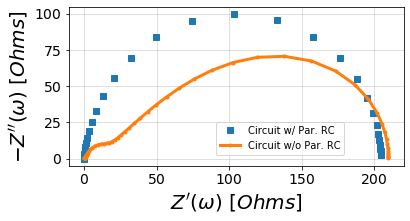

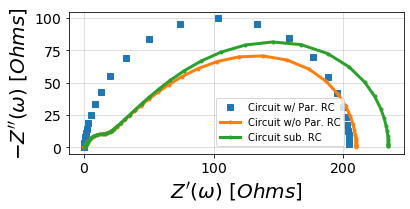

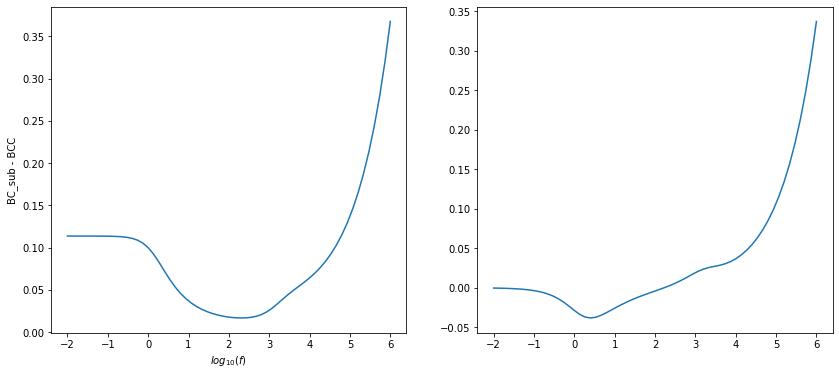

In [99]:
circ = 'p(C1,R1,p(R2,C2)-G1)'
circCorr = 'p(R2,C2)-G1'

vals = [8.233e-4, 8000, 10, 1e-5, 200, .1]
valsCorr = [10, 1e-5, 200, .1]


pred_freq = np.logspace(np.log10(1e6), np.log10(1e-2), num = freqs.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

fig, ax0 = plt.subplots(figsize=(6,6))
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s', label='Circuit w/ Par. RC')
plot_nyquist(ax0, pred_freq, BCC_pred, label='Circuit w/o Par. RC')
fig.legend(loc=(0.525,0.3))
# fig.savefig('Figures\Initial_BerthierCircuit.png', dpi=300, bbox_inches='tight')

RC0 = np.array([3.2, 1e-4])
d_st = 3e-16
x_t = xtol=3e-16
f_t = ftol=3e-16
g_t = gtol=3e-16


resRC= least_squares(IC.Par_RC_Res, RC0, method= 'trf', args=(pred_freq, BC_pred), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
resRC= least_squares(IC.Par_RC_Res, resRC.x, method= 'trf', args=(pred_freq, BC_pred), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)
print(resRC)

LS_only = IC.par_RC_subtract(resRC.x, pred_freq, BC_pred)


fig, ax0 = plt.subplots(figsize=(6,6))
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s', label='Circuit w/ Par. RC')
plot_nyquist(ax0, pred_freq, BCC_pred, label='Circuit w/o Par. RC')
plot_nyquist(ax0, pred_freq, LS_only, label='Circuit sub. RC')
fig.legend(loc=(0.525,.3))
# fig.savefig('Figures\Corrected_BerthierCircuit.png', dpi=300, bbox_inches='tight')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))
ax1.plot(np.log10(pred_freq), np.real((LS_only-BCC_pred)/BC_sub))
ax1.set_ylabel('BC_sub - BCC')
ax1.set_xlabel('$log_{10}(f)$')
# fig.savefig('Figures\Correction_Error.png', dpi=300, bbox_inches='tight')

ax2.plot(np.log10(pred_freq), np.imag((LS_only-BCC_pred)/BC_sub))

plt.show()

In [100]:
rrange = ((3,4), (1e-4,1e-3))

bruteout100 = brute(IC.Par_RC_Res, rrange, Ns=100, args=(pred_freq, BC_pred), full_output=True, workers=-1)

resRCout = least_squares(IC.Par_RC_Res, bruteout100[0], method= 'trf', loss='soft_l1', args=(pred_freq, BC_pred), max_nfev=2000, diff_step=d_st, xtol=x_t, ftol=f_t, gtol=g_t)

Bru100_only = IC.par_RC_subtract(bruteout100[0], pred_freq, BC_pred)
LS_Bru100 = IC.par_RC_subtract(resRCout.x, pred_freq, BC_pred)

print(resRC, '\n', bruteout100[0],'\n', resRCout)

 active_mask: array([0., 0.])
        cost: 0.32381278997737184
         fun: array([0.80475187])
        grad: array([ 1.00593984e-01, -1.37890322e+02])
         jac: array([[ 1.25000000e-01, -1.71345139e+02]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 28
        njev: 1
  optimality: 137.89032195647997
      status: 3
     success: True
           x: array([3.20000000e+00, 8.23600947e-04]) 
 [3.11687961e+00 8.23600940e-04] 
  active_mask: array([0., 0.])
        cost: 0.2835986832533979
         fun: array([0.80475187])
        grad: array([  0.        , 111.13709612])
         jac: array([[  0.        , 121.89402462]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 28
        njev: 1
  optimality: 111.13709612063316
      status: 3
     success: True
           x: array([3.11687961e+00, 8.23600940e-04])


In [46]:
print(bruteout100[2][:,77,79], '\n', bruteout100[3][60:80,77:83])

[8.00000000e+03 8.18181818e-04] 
 [[57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.59420739]
 [57.87847218 35.58976839 13.31280595  9.03964086 31.30630173 53.5

In [90]:
print(1/BC_pred, 1/RC[0])
print(1/BC_pred - 1e4)

[2.56376458+5.17573839e+03j 2.16680309+3.80782948e+03j
 1.82689731+2.80148854e+03j 1.5360203 +2.06113912e+03j
 1.28730178+1.51647015e+03j 1.07486527+1.11575699e+03j
 0.89368851+8.20948067e+02j 0.73948347+6.04050436e+02j
 0.60859294+4.44470767e+02j 0.49790083+3.27059299e+02j
 0.40475356+2.40670863e+02j 0.32688988+1.77106306e+02j
 0.26237668+1.30333752e+02j 0.20954833+9.59157290e+01j
 0.16694778+7.05877223e+01j 0.13326861+5.19481389e+01j
 0.10729954+3.82302124e+01j 0.08787601+2.81341862e+01j
 0.07384702+2.07038345e+01j 0.06406709+1.52356017e+01j
 0.05742   +1.12117478e+01j 0.05287176+8.25117288e+00j
 0.0495376 +6.07326796e+00j 0.04673862+4.47136196e+00j
 0.04402654+3.29322478e+00j 0.04116838+2.42674475e+00j
 0.03809967+1.78939110e+00j 0.03486426+1.32044586e+00j
 0.03155843+9.75267572e-01j 0.0282895 +7.21052808e-01j
 0.02515127+5.33705945e-01j 0.02221341+3.95530484e-01j
 0.01951994+2.93529081e-01j 0.01709275+2.18153720e-01j
 0.01493681+1.62387925e-01j 0.01304548+1.21073328e-01j
 0.0114050

In [102]:
Yel = 1/BC_pred
RC = [-4, 8.2e-4]

w = IC.calcw(pred_freq)
Y = Yel - (1 / 10**RC[0]) #- RC[1] * (1j * w)


a = np.diff(Y)
b = np.diff(np.conj(Y))

s = np.real(np.sum(a*b))

LY = np.sqrt(s)

print(s, np.sum(a*b), np.sum(a), np.sum(b))
# print(np.real(np.sum(a*b)), '\n', a)

4078733.1952585806 (4078733.1952585806+0j) (-2.5588776499625965-5175.738328334173j) (-2.5588776499625965+5175.738328334173j)


In [101]:
print(IC.Par_RC_Res([3.3,8e-4], pred_freq, BC_pred))
print(IC.Par_RC_Res([3.2,8e-4], pred_freq, BC_pred))
print(IC.Par_RC_Res([3.1,8e-4], pred_freq, BC_pred))

57.878472182412956
57.878472182412956
57.878472182412956


In [40]:
bruteout100

(array([1.03896093e+03, 8.23600940e-04]),
 0.8047518745861079,
 array([[[1.00000000e+03, 1.00000000e+03, 1.00000000e+03, ...,
          1.00000000e+03, 1.00000000e+03, 1.00000000e+03],
         [1.09090909e+03, 1.09090909e+03, 1.09090909e+03, ...,
          1.09090909e+03, 1.09090909e+03, 1.09090909e+03],
         [1.18181818e+03, 1.18181818e+03, 1.18181818e+03, ...,
          1.18181818e+03, 1.18181818e+03, 1.18181818e+03],
         ...,
         [9.81818182e+03, 9.81818182e+03, 9.81818182e+03, ...,
          9.81818182e+03, 9.81818182e+03, 9.81818182e+03],
         [9.90909091e+03, 9.90909091e+03, 9.90909091e+03, ...,
          9.90909091e+03, 9.90909091e+03, 9.90909091e+03],
         [1.00000000e+04, 1.00000000e+04, 1.00000000e+04, ...,
          1.00000000e+04, 1.00000000e+04, 1.00000000e+04]],
 
        [[1.00000000e-04, 1.09090909e-04, 1.18181818e-04, ...,
          9.81818182e-04, 9.90909091e-04, 1.00000000e-03],
         [1.00000000e-04, 1.09090909e-04, 1.18181818e-04, ...,
   